In [20]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

In [24]:
config = {
    "vocab_size": 14,  # V: 5 special + 9 emojis
    "hidden_size": 8,  # d_model: The main vector size (758 for real BERT)
    "max_position_embeddings": 16,  # max_len: Longest possible sequence (512 for real BERT)
    "type_vocab_size": 2,  # 0 for Sentence A, 1 for Sentence B
    "hidden_dropout_prob": 0.1,  # Standard BERT dropout
    "attention_heads": 1,  # (12 for real BERT)
    "attention_dropout_prob": 0.1,
    "intermediate_size": 32,  # Should be hidden_size * 4
    "hidden_act": "gelu",
    "num_hidden_layers": 2 # (12 for real BERT)
}

TOKEN_TO_ID = {
    '[PAD]': 0,
    '[UNK]': 1,
    '[CLS]': 2,
    '[SEP]': 3,
    '[MASK]': 4,
    '☀️': 5,
    '🌙': 6,
    '🧑': 7,
    '☕': 8,
    '🥐': 9,
    '💻': 10,
    '🏃': 11,
    '📖': 12,
    '😴': 13,
}

ID_TO_TOKEN = {id: token for token, id in TOKEN_TO_ID.items()}
TOKEN_TO_TEXT = {
    '[PAD]': '[PAD]',
    '[UNK]': '[UNK]',
    '[CLS]': '[CLS]',
    '[SEP]': '[SEP]',
    '[MASK]': '[MASK]',
    '☀️': 'day',
    '🌙': 'night',
    '🧑': 'person',
    '☕': 'coffee',
    '🥐': 'food',
    '💻': 'work',
    '🏃': 'run',
    '📖': 'book',
    '😴': 'sleep',
}

In [3]:
def tokenize(sentence, vocab_map):
    """Converts a string of emojis into a list of token IDs."""
    tokens = sentence.split(' ')  # Real BERT applies WordPiece instead of just splitting
    return [vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]


def create_segment_ids(token_ids, sep_id):
    """
    Generates the list of segment IDs (0s and 1s) from a list of token IDs.
    All tokens *before and including* the first [SEP] are segment 0.
    All tokens *after* the first [SEP] are segment 1.
    """
    segment_ids = []
    current_segment = 0
    for token_id in token_ids:
        segment_ids.append(current_segment)
        # If this is the first [SEP] token, flip to segment 1
        if token_id == sep_id and current_segment == 0:
            current_segment = 1
    return segment_ids

In [4]:
# Example of tokenization

sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"

print("TOKENIZATION")

print("Tokens to IDs")
print(f"First sentence: {tokenize(sentence_a, TOKEN_TO_ID)}")
print(f"Second sentence: {tokenize(sentence_b, TOKEN_TO_ID)}")

bert_real_input = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

print("BERT real input")
print(bert_real_input)
tokens = tokenize(bert_real_input, TOKEN_TO_ID)
print(f"Full tokens to IDs: {tokens}")
token_type_ids = create_segment_ids(tokens, sep_id=TOKEN_TO_ID['[SEP]'])
print(f"Token types: {token_type_ids}")

TOKENIZATION
Tokens to IDs
First sentence: [5, 7, 11]
Second sentence: [7, 8, 9]
BERT real input
[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 [SEP]
Full tokens to IDs: [2, 5, 7, 11, 3, 7, 8, 9, 3]
Token types: [0, 0, 0, 0, 0, 1, 1, 1, 1]


In [6]:
class BertEmbeddings(nn.Module):
    """
    Constructs the BERT input embeddings.

    BERT Embeddings are the sum of:
    1. Token Embeddings (Word Embeddings)
    2. Position Embeddings
    3. Segment Embeddings (Token Type Embeddings) to check if a token is in the first or second segment
    """

    def __init__(self, config):
        super().__init__()

        # 1. Token Embeddings
        # A lookup table for our 14-token vocabulary.
        # padding_idx=0 tells nn.Embedding to treat token ID 0 as "padding".
        # Its vector will be all zeros and will not be updated during training.
        self.word_embeddings = nn.Embedding(
            config["vocab_size"],
            config["hidden_size"],
            padding_idx=0
        )

        # 2. Position Embeddings
        # A lookup table for all possible positions (0 to 15).
        # This is a learned representation of *where* a token is.
        self.position_embeddings = nn.Embedding(
            config["max_position_embeddings"],
            config["hidden_size"]
        )

        # 3. Segment (Token Type) Embeddings
        # A lookup table for the sentence type (0 or 1).
        # This is how the model distinguishes Sentence A from Sentence B.
        self.token_type_embeddings = nn.Embedding(
            config["type_vocab_size"],
            config["hidden_size"]
        )

        # --- Post-processing ---
        # We apply Layer Normalization and Dropout *after* summing.
        # This is a standard part of the BERT architecture.
        # LayerNorm stabilizes the values, dropout prevents overfitting.
        # eps=1e-12 is from the paper. we use 1e-5
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, input_ids, token_type_ids):
        """
        Forward pass for the embeddings.

        Args:
            input_ids (torch.Tensor): Shape (batch_size, seq_length).
                                      The token IDs.
            token_type_ids (torch.Tensor): Shape (batch_size, seq_length).
                                           The segment IDs (0s and 1s).

        Returns:
            torch.Tensor: Shape (batch_size, seq_length, hidden_size).
                          The final input embeddings.
        """
        # --- 1. Get Token Embeddings ---
        # input_ids shape: (batch_size, seq_len)
        # words_embeddings shape: (batch_size, seq_len, hidden_size)
        words_embeddings = self.word_embeddings(input_ids)

        # --- 2. Get Segment Embeddings ---
        # token_type_ids shape: (batch_size, seq_len)
        # token_type_embeddings shape: (batch_size, seq_len, hidden_size)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # --- 3. Get Position Embeddings ---
        # We need to create the position IDs on the fly.
        # If input_ids is (batch, 9), we need position_ids (batch, 9)
        # that looks like [[0, 1, 2, 3, 4, 5, 6, 7, 8]]

        # Get the sequence length: e.g., 9
        seq_length = input_ids.size(1)

        # Create a tensor of [0, 1, 2, ..., seq_length-1]
        # shape: (seq_length)
        position_ids = torch.arange(
            seq_length,
            dtype=torch.long,
            device=input_ids.device
        )

        # Make it (1, seq_length) and expand it to match the batch size
        # shape: (batch_size, seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # Look up the position embeddings
        # shape: (batch_size, seq_len, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)

        # --- Create the final embeddings ---
        # Add all three embedding vectors together element-wise.
        embeddings = words_embeddings + position_embeddings + token_type_embeddings

        # --- Post-processing ---
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [8]:
# Example of Embedding (not trained, so meaningless)
# Notice that the same token 🧑 is embedded in different ways thanks to position and segment

sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐 🏃 ☕"

input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(f"Input string: {input_string}")

token_ids = tokenize(input_string, TOKEN_TO_ID)
# Convert to a PyTorch tensor (batch_size = 1)
# shape: (1, 9)
input_ids = torch.tensor([token_ids])

print(f"Input IDs:    {input_ids}")

# 3. Create the Segment IDs
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

print(f"Input IDs shape:        {input_ids.shape}")
print(f"Token Type IDs shape: {token_type_ids.shape}")

embedding_module = BertEmbeddings(config)
embedding_module.eval()
with torch.no_grad():
    output_embeddings = embedding_module(input_ids, token_type_ids)

# 11 is the number of tokens, 8 is the size of each embedding
print(f"\nOutput embeddings shape: {output_embeddings.shape}")
print("\nEmbeddings\n")
print(output_embeddings[0])

Input string: [CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input IDs:    tensor([[ 2,  5,  7, 11,  3,  7,  8,  9, 11,  8,  3]])
Input IDs shape:        torch.Size([1, 11])
Token Type IDs shape: torch.Size([11])

Output embeddings shape: torch.Size([1, 11, 8])

Embeddings

tensor([[ 1.5627,  0.4329, -1.5390, -0.0726, -0.2969, -0.0361, -1.2309,  1.1799],
        [ 0.8051, -1.0775,  0.2378,  1.6661, -1.6972,  0.2131, -0.5326,  0.3851],
        [ 0.1806,  0.5513,  0.7908,  1.4726,  0.5577, -0.7458, -1.2270, -1.5801],
        [-0.5868,  1.0149,  0.2936, -0.7513,  1.9319,  0.0992, -1.3398, -0.6617],
        [ 0.1663,  1.0485,  0.0258,  0.7175, -1.3209,  1.2846, -1.7078, -0.2139],
        [-0.0373,  1.3821,  1.1151,  0.6855,  0.2881, -0.6538, -1.3677, -1.4120],
        [-0.9913,  0.1089, -0.1372,  0.2055,  1.9543, -1.2245,  0.9427, -0.8584],
        [-1.1860, -0.1954,  0.3719,  1.7203, -0.9207,  1.2891, -0.9672, -0.1119],
        [-0.3916,  0.6429,  0.7144,  0.8775,  0.6818,  0.6945, -1.7173, -1.5022],

In [12]:
# Self-Attention is basically a way to represent a token as the weighted average of all the other tokens.
# This way, the meaning of the token embeds its context

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config['attention_heads']
        self.dropout_prob = config['attention_dropout_prob']
        self.hidden_size = config['hidden_size']

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError("The hidden size is not a multiple of the number of attention heads")

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)

        # In a multi-head setup, all_head_size would be (num_heads * head_size).
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # --- The 3 Linear Layers ---
        # These project the input embeddings (d_model=8) into Q, K, and V.
        self.Q = nn.Linear(self.hidden_size, self.all_head_size)
        self.K = nn.Linear(self.hidden_size, self.all_head_size)
        self.V = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (This is the output from our BertEmbeddings)

        Returns:
            context_layer (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (The context-aware embeddings)
            attention_probs (torch.Tensor): Shape (batch_size, num_heads, seq_length, seq_length)
                                            (The attention weights, for visualization)
        """

        # 1. Project to Q, K, V
        Q = self.Q(hidden_states)
        K = self.K(hidden_states)
        V = self.V(hidden_states)

        # NOTE: In a *multi-head* setup, we would now split (batch, seq_len, 8)
        # into (batch, num_heads, seq_len, head_size).
        # Since num_heads=1, we can just add a "dummy" head dimension.
        # Q: (batch, 1, seq_len, 8)
        Q = Q.view(Q.size(0), Q.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # 2. Calculate Attention Scores (Q @ K.T)
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))

        # 3. Scale the scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # 4. Apply Softmax to get probabilities
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # Apply dropout to the probabilities
        attention_probs = self.dropout(attention_probs)

        # 5. Get Weighted Sum of Values (Weights @ V)
        context_layer = torch.matmul(attention_probs, V)

        # NOTE: In a *multi-head* setup, we'd now "un-split" the heads:
        # 1. Transpose: (batch, seq_len, num_heads, head_size)
        # 2. Reshape:  (batch, seq_len, all_head_size)
        # We do it here just to be architecturally correct.
        context_layer = context_layer.transpose(1, 2).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # We return both the final vectors and the attention weights
        return context_layer, attention_probs

    @staticmethod
    def plot_attention_heatmap(attention_matrix, token_ids, head_index=0, batch_item=0):
        matrix = attention_matrix[batch_item, head_index].to('cpu').detach().numpy()
        tokens = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
        seq_len = len(tokens)

        fig, ax = plt.subplots(figsize=(9, 5 * attention_matrix.shape[0]))
        im = ax.imshow(matrix, cmap='Reds')

        ax.set_xticks(np.arange(seq_len))
        ax.set_yticks(np.arange(seq_len))
        ax.set_xticklabels(tokens)
        ax.set_yticklabels(tokens)

        # The Y-axis is the "Query" (the token *doing* the looking)
        # The X-axis is the "Key" (the token *being* looked at)
        ax.set_ylabel("Query (Token 'looking')")
        ax.set_xlabel("Key (Token 'being looked at')")
        ax.set_title(f"Attention Weights (Head {head_index})")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        threshold = matrix.max() * 0.6
        for i in range(seq_len):
            for j in range(seq_len):
                val = matrix[i, j]
                color = "white" if val < threshold else "black"
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color)

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        plt.show()

[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input embeddings shape: torch.Size([1, 11, 8])

Context Vectors shape:  torch.Size([1, 11, 8])
Attention Matrix shape: torch.Size([1, 1, 11, 11])


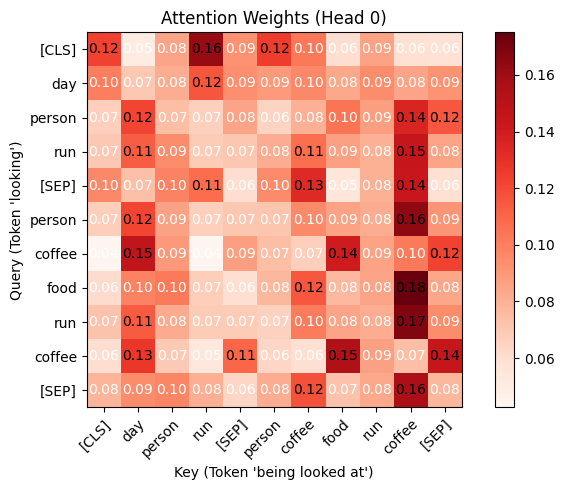

In [14]:
# Example of Attention (again, not trained so meaningless)

input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(input_string)
token_ids = tokenize(input_string, TOKEN_TO_ID)
input_ids = torch.tensor([token_ids])
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

print(f"Input embeddings shape: {input_embeddings.shape}")

attention_module = SelfAttention(config=config)
attention_module.eval()
with torch.no_grad():
    context_vectors, attention = attention_module(input_embeddings)

print(f"\nContext Vectors shape:  {context_vectors.shape}")
print(f"Attention Matrix shape: {attention.shape}")
SelfAttention.plot_attention_heatmap(attention_matrix=attention, token_ids=token_ids)

In [17]:
class BertSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attention_module = SelfAttention(config)
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, hidden_states):
        context_vectors, attention_probs = self.attention_module(hidden_states)
        attention_output = self.dense(context_vectors)
        attention_output = self.dropout(attention_output)
        return attention_output, attention_probs


class BertAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.self_attention = BertSelfAttention(config)
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        attention_output, attention_probs = self.self_attention(hidden_states)
        # The "Add & Norm" step:
        # hidden_states is the *original input* to this block
        summed_output = attention_output + hidden_states # "Add"
        normed_output = self.LayerNorm(summed_output) # "Norm"
        return normed_output, attention_probs

In [18]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["intermediate_size"])
        if config["hidden_act"] == "gelu":
            self.intermediate_act_fn = nn.GELU()
        else:
            self.intermediate_act_fn = nn.ReLU()

    def forward(self, hidden_states):
        dense_output = self.dense(hidden_states)
        activated_output = self.intermediate_act_fn(dense_output)
        return activated_output


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, intermediate_output, attention_output):
        dense_output = self.dense(intermediate_output)
        dropped_output = self.dropout(dense_output)
        # The *second* "Add & Norm" step
        # 1. Add the residual (from the *output* of the attention layer)
        # 2. Apply Layer Normalization
        summed_output = dropped_output + attention_output
        normed_output = self.LayerNorm(summed_output)
        return normed_output

In [19]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, return_attention_output=False):
        """
        Args:
            hidden_states (torch.Tensor): (batch, seq_len, 8)

        Returns:
            layer_output (torch.Tensor): (batch, seq_len, 8)
            attention_probs (torch.Tensor): (batch, 1, seq_len, seq_len)
        """

        attention_output, attention_probs = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        if return_attention_output:
            return layer_output, attention_probs, attention_output
        else:
            return layer_output, attention_probs

In [21]:
def token_journey(matrixes, token_ids, titles, sleep_time=1):
    token_names = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
    for i, matrix in enumerate(matrixes):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, .6 * matrix.shape[0]))
        ax.set_title(titles[i])
        ax.imshow(matrix, cmap='Reds', aspect='auto')
        ax.set_xticks(np.arange(matrix.shape[1]))
        ax.set_xticklabels(np.arange(matrix.shape[1]))
        ax.set_yticks(np.arange(len(token_names)))
        ax.set_yticklabels(token_names)
        plt.tight_layout()
        plt.show()
        time.sleep(sleep_time)


In [22]:
sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"
input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

TOKEN_TO_TRACK = "🥐"
TOKEN_NAME = TOKEN_TO_TEXT[TOKEN_TO_TRACK]
TRACKED_TOKEN_INDEX = input_string.split(' ').index(TOKEN_TO_TRACK)
print(f"Tracking token '{TOKEN_TO_TRACK}' at index {TRACKED_TOKEN_INDEX}")

# --- 1. Get Token & Segment IDs ---
token_id_list = tokenize(input_string, TOKEN_TO_ID)
segment_id_list = create_segment_ids(token_id_list, TOKEN_TO_ID['[SEP]'])
input_ids = torch.tensor([token_id_list])
token_type_ids = torch.tensor([segment_id_list])

# --- 2. Run Module 1 (Embeddings) ---
embedding_module = BertEmbeddings(config)
embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

# --- 3. Run Module 3 (BertLayer) ---
bert_layer = BertLayer(config)
bert_layer.eval()
with torch.no_grad():
    layer_output, attention_scores, attention_output = bert_layer(
        input_embeddings, return_attention_output=True
    )

# --- 4. Get the 3 "Pages" for our token ---
page1 = input_embeddings.squeeze(0)[TRACKED_TOKEN_INDEX]
page2 = attention_output.squeeze(0)[TRACKED_TOKEN_INDEX]
page3 = layer_output.squeeze(0)[TRACKED_TOKEN_INDEX]

print(f"Vector for '{TOKEN_TO_TRACK}' (Page 1): {page1.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 2): {page2.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 3): {page3.shape}")

Tracking token '🥐' at index 7
Vector for '🥐' (Page 1): torch.Size([8])
Vector for '🥐' (Page 2): torch.Size([8])
Vector for '🥐' (Page 3): torch.Size([8])


In [23]:
titles = ['Embbeding layer', 'Attention layer', 'Feed Forward layer']
token_journey([
    input_embeddings.squeeze(0),
    attention_output.squeeze(0),
    layer_output.squeeze(0)], token_ids=[int(x) for x in input_ids[0]],
    titles=titles, sleep_time=2)

In [25]:
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([
            BertLayer(config) for _ in range(config["num_hidden_layers"])
        ])

    def forward(self, hidden_states, output_all_layers=True):
        all_hidden_states = ()
        all_attentions = ()

        for layer_module in self.layer:
            if output_all_layers:
                all_hidden_states = all_hidden_states + (hidden_states,)
            hidden_states, attention_probs = layer_module(hidden_states)
            if output_all_layers:
                all_attentions = all_attentions + (attention_probs,)
        if output_all_layers:
            all_hidden_states = all_hidden_states + (hidden_states,)
        return all_hidden_states, all_attentions

In [27]:
class BertPooler(nn.Module):
    """
    BertPooler is needed for the "pooling" of the [CLS] token.
    This special token is where the Bert Encoder embeds the meaning of the entire sentence.

    But how do we force the network to put the whole meaning in this special token?
    By extracting this embedding and use it for the classification task.
    In order to perform well, the network is forced to put the meaning of the sentence in the [CLS] token
    """
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We just grab the vector for the *first token* ([CLS])
        first_token_tensor = hidden_states[:, 0]
        # Pass it through the dense layer and activation
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [28]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids):
        embedding_output = self.embeddings(input_ids, token_type_ids)
        all_hidden_states, all_attentions = self.encoder(embedding_output)
        sequence_output = all_hidden_states[-1]
        pooled_output = self.pooler(sequence_output)
        # We return the last layer's vectors and the [CLS] vector
        # Just for demo purposes, we get also all the attentions
        # (We can add all_hidden_states/all_attentions later if needed)
        return sequence_output, pooled_output, all_attentions

In [29]:
tiny_bert_model = BertModel(config)
tiny_bert_model.eval()

with torch.no_grad():
    sequence_output, pooled_output, attentions = tiny_bert_model(input_ids, token_type_ids)

print("--- Output from full BertModel ---")
print(f"Final Sequence Output shape: {sequence_output.shape}")
print(f"Final Pooled Output shape:   {pooled_output.shape}")

print("\n--- Pooled Output Vector ([CLS] token) ---")
print(pooled_output)

--- Output from full BertModel ---
Final Sequence Output shape: torch.Size([1, 9, 8])
Final Pooled Output shape:   torch.Size([1, 8])

--- Pooled Output Vector ([CLS] token) ---
tensor([[-0.6448, -0.0058,  0.7153, -0.6898,  0.1271,  0.7093,  0.2573, -0.1200]])


## BERT Pre-Training

In [30]:
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        if config["hidden_act"] == "gelu":
            self.transform_act_fn = nn.GELU()
        else:
            self.transform_act_fn = nn.ReLU()
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)
        # The "decoder" layer that maps 8 -> 14
        # Note: We set bias=False because we'll add it manually.
        self.decoder = nn.Linear(config["hidden_size"], config["vocab_size"], bias=False)

        # We add the bias as a separate parameter
        self.bias = nn.Parameter(torch.zeros(config["vocab_size"]))

        # Manually set the decoder's bias to our new parameter
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states

In [31]:
class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.mlm_head = BertLMPredictionHead(config)
        self.nsp_classifier = nn.Linear(config["hidden_size"], 2)
        self.tie_weights()

    def tie_weights(self):
        """
        Tie the weights between the token embeddings and the MLM decoder.
        This is a *critical* part of the BERT design.
        """
        # Get the weight matrix from our embedding layer (Module 1)
        embedding_weights = self.bert.embeddings.word_embeddings.weight

        # Set the MLM decoder's weight to be the *same* matrix
        self.mlm_head.decoder.weight = embedding_weights

        # And make sure the bias is still our learned 'self.mlm_head.bias'
        self.mlm_head.decoder.bias = self.mlm_head.bias

    def forward(self, input_ids, token_type_ids):
        sequence_output, pooled_output, attentions = self.bert(input_ids, token_type_ids)
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_classifier(pooled_output)
        return mlm_logits, nsp_logits, attentions

In [33]:
final_model = BertForPreTraining(config)
final_model.eval()

print("--- Checking Weight Tying ---")
# Get memory addresses
emb_weights_ptr = final_model.bert.embeddings.word_embeddings.weight.data_ptr()
dec_weights_ptr = final_model.mlm_head.decoder.weight.data_ptr()

print(f"Embedding Weight Pointer: {emb_weights_ptr}")
print(f"Decoder Weight Pointer:   {dec_weights_ptr}")
print(f"Weights are tied:         {emb_weights_ptr == dec_weights_ptr}")

with torch.no_grad():
    mlm_logits, nsp_logits, attentions = final_model(input_ids, token_type_ids)

print("\n--- Final Logit Output Shapes ---")
print(f"MLM Logits shape: {mlm_logits.shape}")
print(f"NSP Logits shape: {nsp_logits.shape}")

print("\n--- MLM Logits (for token 1) ---")
# The scores for the 14 vocab words for the 2nd token ('☀️')
print(mlm_logits[0, 1, :])

print("\n--- NSP Logits ([CLS] token) ---")
# The scores for 'IsNext' and 'NotNext'
print(nsp_logits[0, :])

--- Checking Weight Tying ---
Embedding Weight Pointer: 890364544
Decoder Weight Pointer:   890364544
Weights are tied:         True

--- Final Logit Output Shapes ---
MLM Logits shape: torch.Size([1, 9, 14])
NSP Logits shape: torch.Size([1, 2])

--- MLM Logits (for token 1) ---
tensor([ 0.0000, -0.1043, -2.3108,  1.0201, -1.4443,  3.3306,  1.6308,  4.9265,
         2.2070,  1.2248, -1.7294, -3.1095,  1.8641, -3.7046])

--- NSP Logits ([CLS] token) ---
tensor([-0.5156,  0.5527])
